In [1]:
!pip install --upgrade --no-cache-dir gdown >/dev/null
!gdown 1kTJmHH3qEyivtSJvnVUMYpWnZcQl5XaV

Downloading...
From: https://drive.google.com/uc?id=1kTJmHH3qEyivtSJvnVUMYpWnZcQl5XaV
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 31.2MB/s]


In [2]:
!unzip Bigdata_hw2_datasets.zip

Archive:  Bigdata_hw2_datasets.zip
   creating: Bigdata_hw2_datasets/
   creating: Bigdata_hw2_datasets/q1/
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
   creating: Bigdata_hw2_datasets/q2/
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
   creating: Bigdata_hw2_datasets/q3/
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  


In [3]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 57.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5bc0055ada1372b18e5885f6f14d7d6e12cf623f23b3500c540e1a93b444fd61
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import math

INPUT_DIR = 'Bigdata_hw2_datasets/q3/'
DATA_FILE = INPUT_DIR + 'data.txt'
C1_FILE = INPUT_DIR + 'c1.txt'
C2_FILE = INPUT_DIR + 'c2.txt'

MAX_ITER = 20
K = 10
NDATA = 4601
NDIM = 58

In [12]:
def l1(u, v):
    """Manhattan Distance"""
    return sum(map(lambda a, b: abs(a - b), u, v))


def l2(u, v):
    """Euclidian distance"""
    return math.sqrt(sum(map(lambda a, b: (a - b) ** 2, u, v)))


def find_centroid(p, centroids, dist_func, itcost):
    """Find the closest centroid for p."""
    mind = float('inf')
    mini = -1
    for ci, cp in enumerate(centroids):
        d = dist_func(p, cp)
        if d < mind:
            mind = d
            mini = ci
    itcost += mind ** 2
    return mini, p


def agg_uv(a, p):
    """Calculate the sum vector of two points and their counts."""
    s = list(map(lambda x1, x2: x1 + x2, a[0], p))
    return s, a[1] + 1


def agg_uu(a, b):
    """Calculate the sum vector of two points and their counts."""
    s = list(map(lambda x1, x2: x1 + x2, a[0], b[0]))
    return s, a[1] + b[1]


def change_perc(costs):
    return abs(costs[10] - costs[0]) / costs[0]


def kmeans(sc, data, cfile, dist_func):
    centroids = []
    costs = []
    itcost = sc.accumulator(0)

    # Load the centroid file
    with open(cfile) as f:
        for l in f:
            centroids.append(list(map(float, l.split())))

    for it in range(MAX_ITER):
        # Assign each point to the cluster with closest centroid.
        # Consider centroid index as the key and point as the value.
        ci_p = data.map(lambda p: find_centroid(
            p, centroids, dist_func, itcost))

        # Calculate sum vector and the number of points in each cluster.
        ci_sv_cnt = ci_p.aggregateByKey(
            ([0] * NDIM, 0), agg_uv, agg_uu)

        # Iterate through the clusters.
        # Recompute the centroid of each cluster as the mean of all its points.
        for ci, sv_cnt in ci_sv_cnt.collect():
            sv, cnt = sv_cnt
            centroids[ci] = [s / cnt for s in sv]

        # Store the cost and reset it for new iteration.
        costs.append(itcost.value)
        itcost.value = 0

    return costs

In [6]:
# Create spark context and load data.
sc = SparkContext.getOrCreate()
data = sc.textFile(DATA_FILE)
data = data.map(lambda l: list(map(float, l.split())))
iters = list((range(1, MAX_ITER + 1)))

C1 Costs: [623660345.3064115, 509862908.2975454, 485480681.8720084, 463997011.68501294, 460969266.57299685, 460537847.9827684, 460313099.6535447, 460003523.8894082, 459570539.31773525, 459021103.3422909, 458490656.19198126, 457944232.5879751, 457558005.19867724, 457290136.35230196, 457050555.0595629, 456892235.6153559, 456703630.7370345, 456404203.01897514, 456177800.541994, 455986871.02734685]
C2 Costs: [438747790.02791756, 249803933.62600276, 194494814.40631253, 169804841.4515432, 156295748.80627593, 149094208.10896596, 142508531.61961532, 132303869.40652987, 117170969.83719076, 108547377.17857003, 102237203.3179959, 98278015.74975666, 95630226.12177408, 93793314.051193, 92377131.96821064, 91541606.25423889, 91045573.83042455, 90752240.10140808, 90470170.18122731, 90216416.1756313]
C1 Change: 0.2648391714456055
C2 Change: 0.7669795594605946


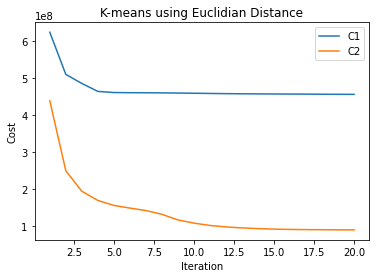

In [13]:
c1_l2_costs = kmeans(sc, data, C1_FILE, l2)
c2_l2_costs = kmeans(sc, data, C2_FILE, l2)

print("C1 Costs:", c1_l2_costs)
print("C2 Costs:", c2_l2_costs)
print("C1 Change:", change_perc(c1_l2_costs))
print("C2 Change:", change_perc(c2_l2_costs))

plt.title("K-means using Euclidian Distance")
plt.plot(iters, c1_l2_costs, label="C1")
plt.plot(iters, c2_l2_costs, label="C2")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

C1 Costs: [911884445.1718692, 742776334.1127646, 710494810.194144, 691533974.0581697, 684107578.3598723, 679414600.2305121, 674715277.5707939, 661774250.0973034, 638253018.6656508, 534847013.70820457, 349879440.5947107, 321182673.4072134, 318741119.06619465, 316453910.3334702, 313858408.80319655, 312009204.70386994, 310765768.44007146, 308057164.01579016, 305352257.65883255, 303165896.02685046]
C2 Costs: [655439563.7534091, 425797401.1688459, 340841790.15862554, 300225433.73989064, 288288125.2596762, 280744103.44819236, 263746381.6036476, 245483161.49866766, 210918225.27613884, 194368603.12692153, 187496282.87738794, 185418200.7572966, 183521866.8970892, 182150585.44948786, 181485856.88127467, 180706294.44807574, 179645731.17449278, 178877228.155527, 178431912.69330713, 178185258.5584315]
C1 Change: 0.6163116473285533
C2 Change: 0.7139381062020721


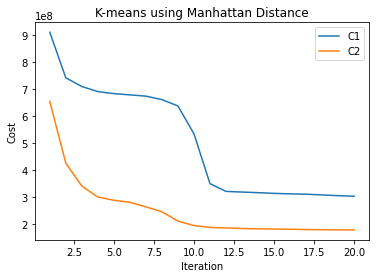

In [14]:
c1_l1_costs = kmeans(sc, data, C1_FILE, l1)
c2_l1_costs = kmeans(sc, data, C2_FILE, l1)

print("C1 Costs:", c1_l1_costs)
print("C2 Costs:", c2_l1_costs)
print("C1 Change:", change_perc(c1_l1_costs))
print("C2 Change:", change_perc(c2_l1_costs))

plt.title("K-means using Manhattan Distance")
plt.plot(iters, c1_l1_costs, label="C1")
plt.plot(iters, c2_l1_costs, label="C2")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()